In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import norm, skew

%matplotlib inline

In [85]:
os.chdir("../")

In [89]:
data = pd.read_csv('artifacts/data_ingestion/winequality-red.csv')

In [90]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [91]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Label Distribution

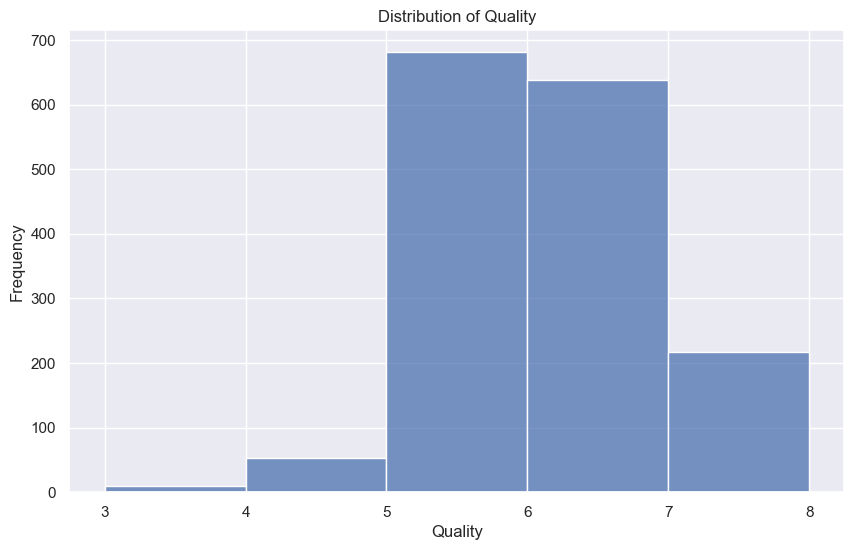

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(data['quality'], bins=5)
plt.title('Distribution of Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

There are 5 different values in our target column. This column has unequal distribution, values 3 and 4 are underrepresented. We can apply some oversampling technique to reduce the biases of our future model.

In [93]:
data['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

## Data Correlation

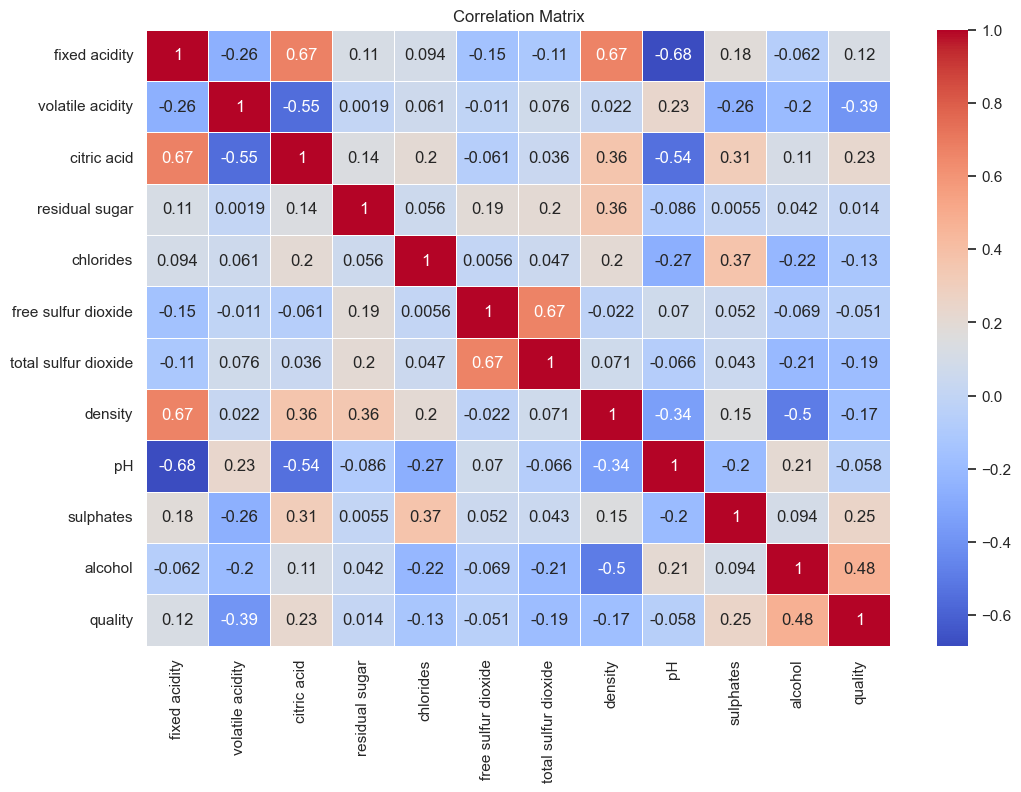

In [94]:
corrmat = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Note that there aren't many high or low correlations in our dataset. The only thing that catches the eye is correlation between 'alcohol' and 'quality'. Even thought it's the highest correlation of target variable, it is still not high on the absolute scale. There is no multicollinearity in the data, so we don't need to do any feature engineering.

## Data Distribution

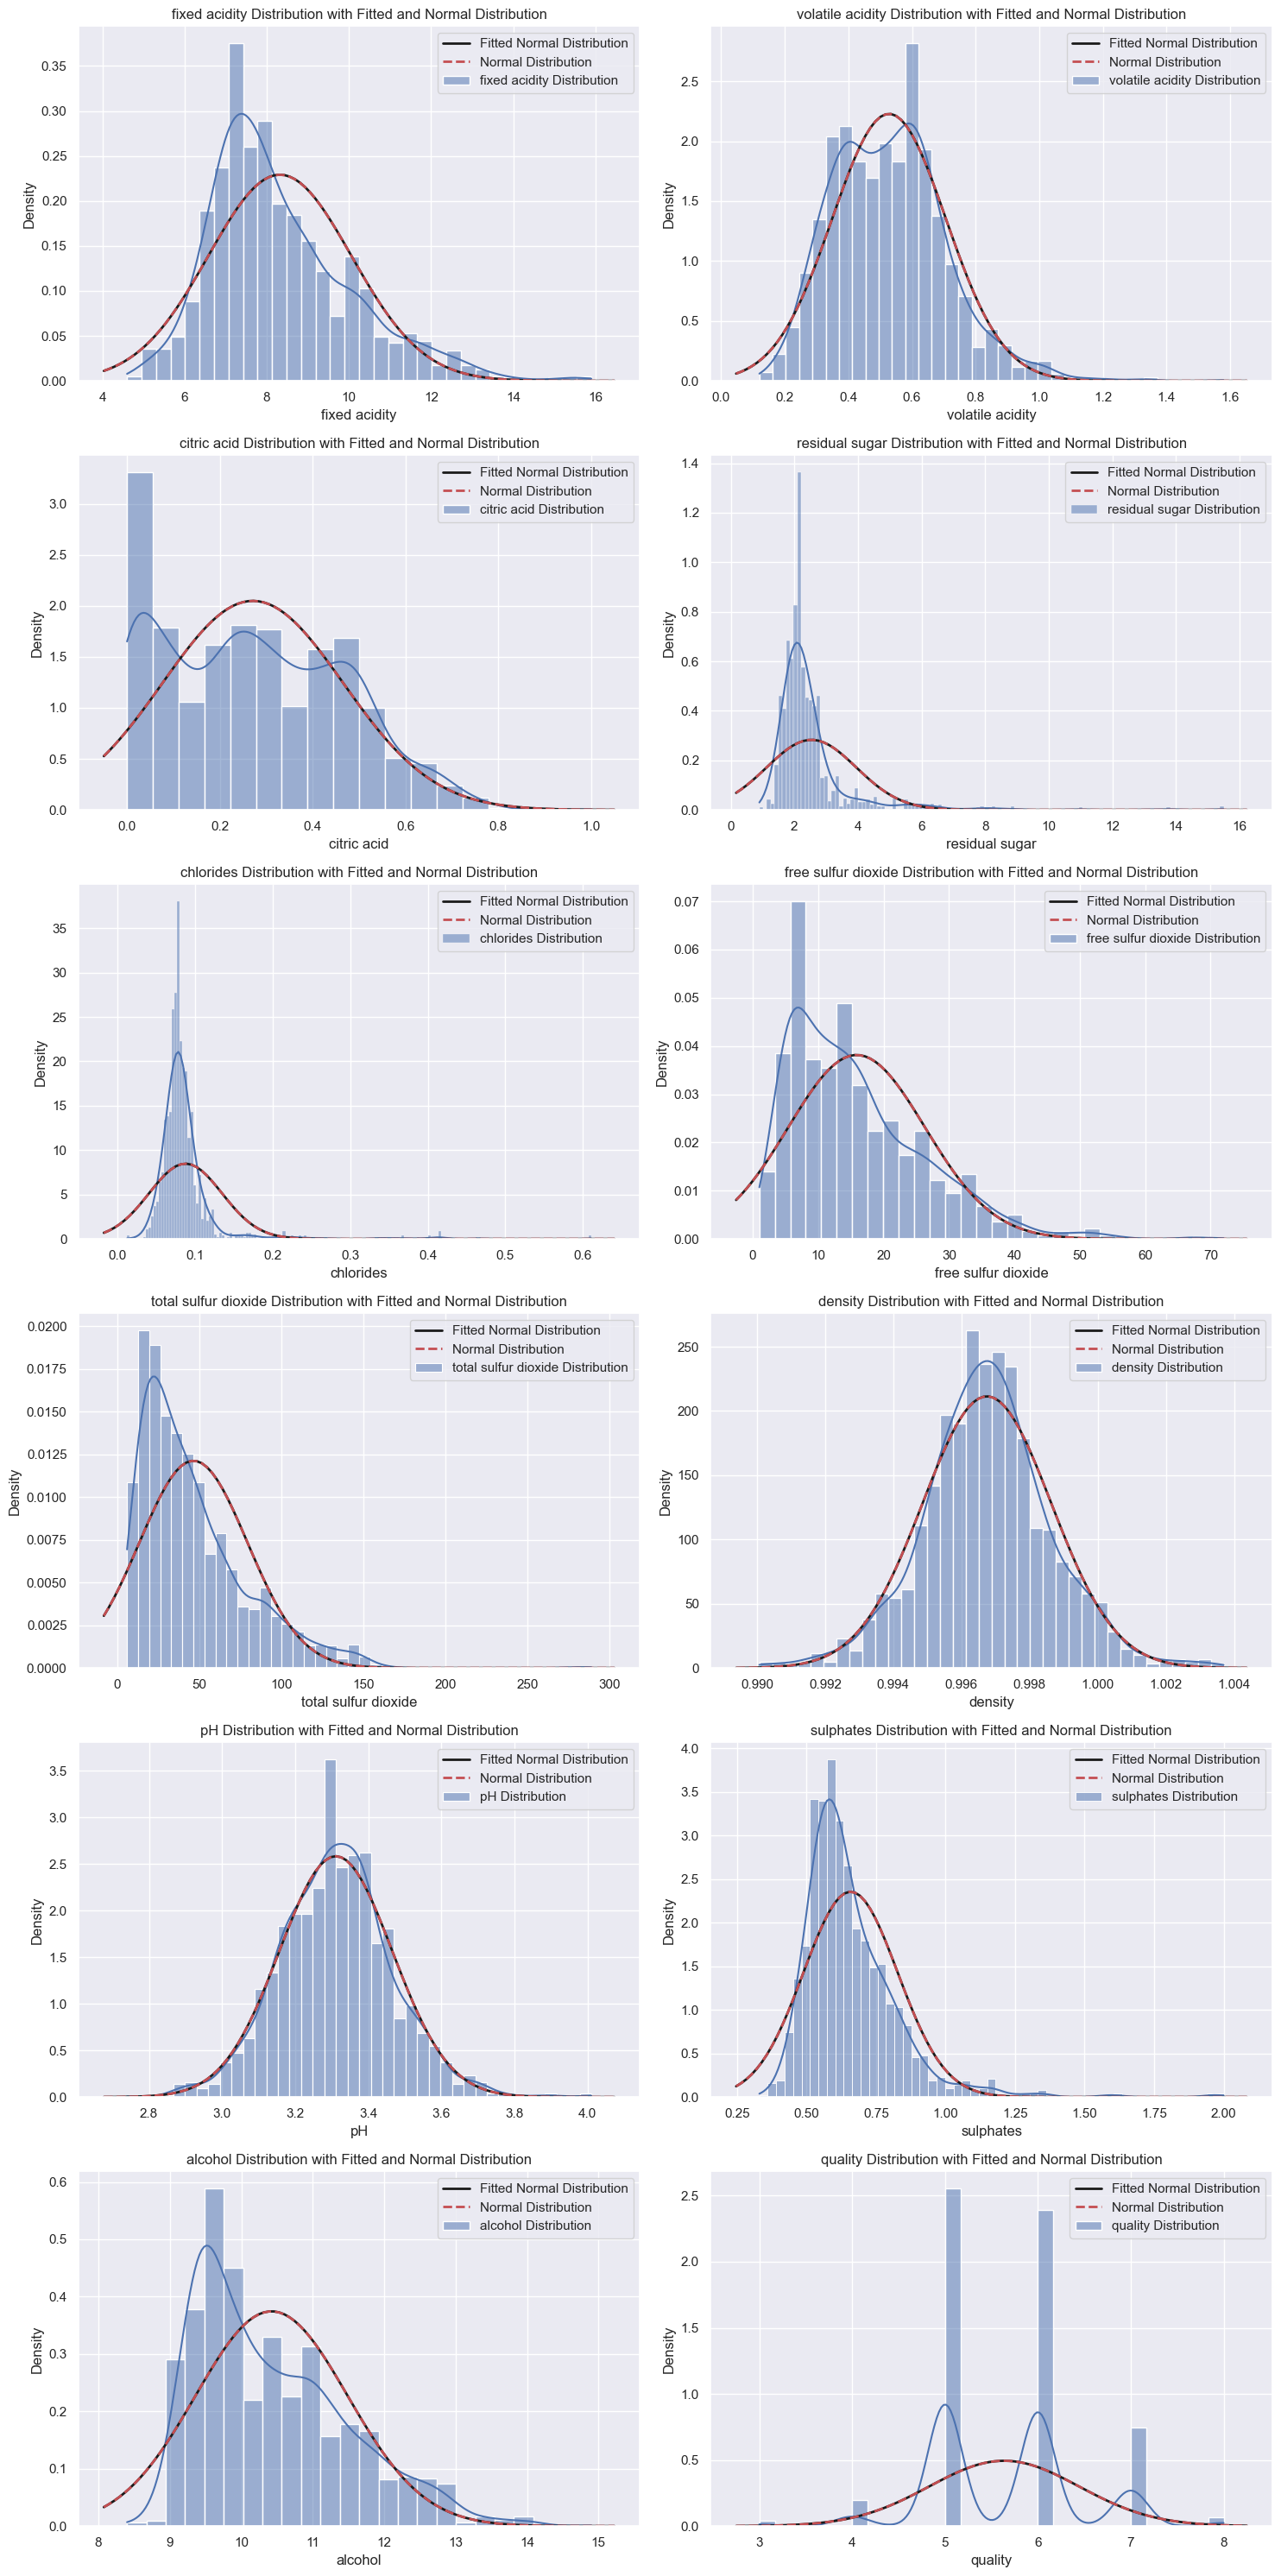

In [95]:
n_cols = 2
n_rows = int(np.ceil(len(data.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]

    # plot column
    sns.histplot(data[column], kde=True, stat="density", label=f'{column} Distribution', ax=ax)

    mu, std = norm.fit(data[column])

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')

    # plot Normal Distribution
    mean = data[column].mean()
    std_dev = data[column].std()
    p_normal = norm.pdf(x, mean, std_dev)
    ax.plot(x, p_normal, 'r--', linewidth=2, label='Normal Distribution')

    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title(f'{column} Distribution with Fitted and Normal Distribution')
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From these plots we can see, that many features are right-skewed. Let's explore their skewness and remove it.

In [97]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness


Skew in numerical features: 



,Skew
chlorides,5.675017
residual sugar,4.536395
sulphates,2.426393
total sulfur dioxide,1.514109
free sulfur dioxide,1.249394
fixed acidity,0.981829
alcohol,0.860021
volatile acidity,0.670962
citric acid,0.318039
quality,0.217597


We will engineer features that have absolute skewness higher than 0.75.

In [45]:
skewness = skewness[abs(skewness['Skew']) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 7 skewed numerical features to Box Cox transform


Let's first explore the best lambda value.

In [98]:
from scipy.special import boxcox1p, boxcox

skewed_features = skewness.index
best_lam = 0
min_skew = filtered_skew = skewness['Skew'][skewness['Skew'].abs() > 0.75].sum()

for lam in np.arange(0, 1.05, step=0.05):
    total_abs_skew = 0
    for feat in skewed_features:
        total_abs_skew += np.abs(skew(boxcox(data[feat]+1e-6, lam).dropna()))

    if total_abs_skew < min_skew:
        min_skew = total_abs_skew
        best_lam = lam

print(f"Best lambda: {best_lam}")
print(f"Minimum value for skew: {min_skew}")

Best lambda: 0.05
Minimum value for skew: 9.348093880391653


Best lambda value is 0.5. Let's apply boxcox function to reduce skewness.

In [99]:
skewed_features = skewness.index
lam = 0.5
for feat in skewed_features:
    data[feat] = boxcox(data[feat]+1e-6, lam)

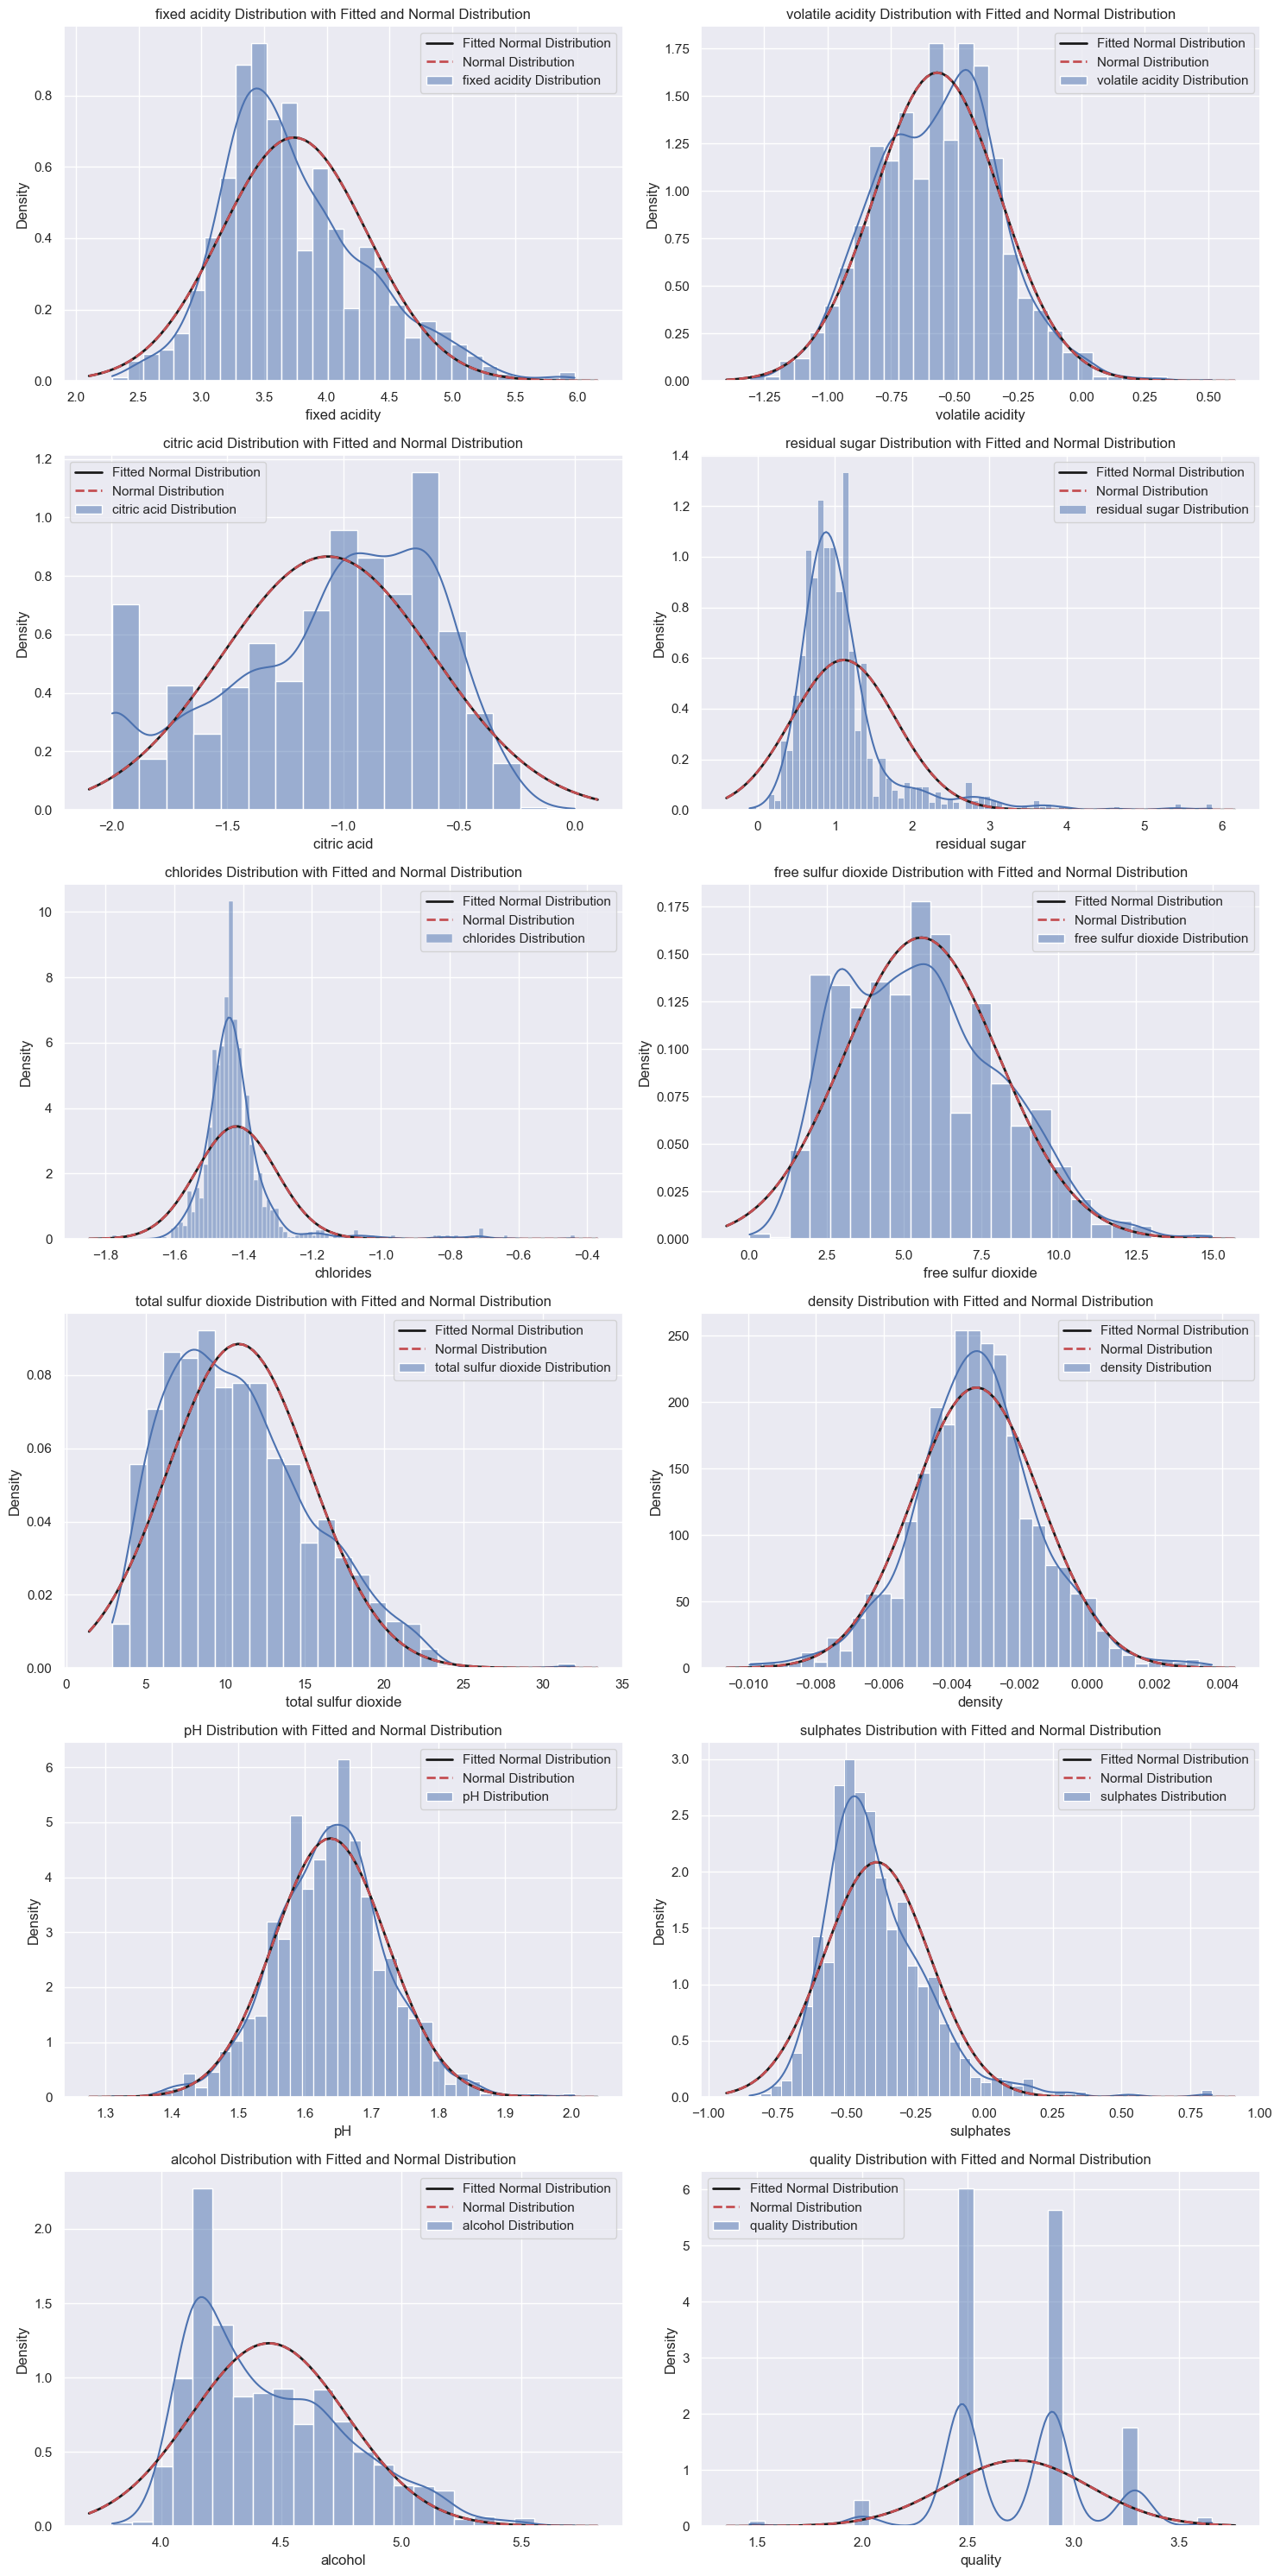

In [100]:
n_cols = 2
n_rows = int(np.ceil(len(data.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]

    # plot column
    sns.histplot(data[column], kde=True, stat="density", label=f'{column} Distribution', ax=ax)

    mu, std = norm.fit(data[column])

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')

    # plot Normal Distribution
    mean = data[column].mean()
    std_dev = data[column].std()
    p_normal = norm.pdf(x, mean, std_dev)
    ax.plot(x, p_normal, 'r--', linewidth=2, label='Normal Distribution')

    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title(f'{column} Distribution with Fitted and Normal Distribution')
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [101]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
chlorides,3.705325
residual sugar,2.953989
sulphates,1.553084
alcohol,0.758039
fixed acidity,0.684363
total sulfur dioxide,0.639838
free sulfur dioxide,0.482891
volatile acidity,0.108255
pH,0.098694
density,0.067073


We now can see that our skewness was dramatically reduced for many features. That should help our models in the future.

## Train/val/test Split

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    data.drop('quality', axis=1), data['quality'],
    shuffle=True,
    stratify=data['quality'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    shuffle=True,
    stratify=y_temp,
    test_size=0.5,
    random_state=42
)

In [69]:
print(f"Shape of train data: {X_train.shape}")
print(f"Shape of validation data: {X_val.shape}")
print(f"Shape of test data: {X_test.shape}")

Shape of train data: (1119, 11)
Shape of validation data: (240, 11)
Shape of test data: (240, 11)


## Feature Scaling

In [65]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [72]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Oversampling

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
smote = SMOTE(random_state=42)

In [ ]:
print("Counts of target values before oversampling")
y_train.value_counts()

In [75]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [76]:
print(f"Shape of train data after oversampling: {X_train.shape}")

Shape of train data after oversampling: (2862, 11)


In [83]:
print("Counts of target values after oversampling")
y_train.value_counts()

Counts of target values after oversampling


quality
6    477
5    477
7    477
4    477
3    477
8    477
Name: count, dtype: int64